# Cat & Dog Breed CNN CLassification

## Part 1: Setup

Importing libraries

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.inception_v3 import preprocess_input
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn import metrics
import pydot

First you need to download dataset from Kaggle and extract the zip file in this directory befrore starting

In [3]:
# Getting list of images (excluding some that do not open)
ROOT = 'archive'
IMGS_PATH = 'archive/images/images'
TRIMAP_PATH = 'archive/annotations/annotations/trimaps'

bad = {'Abyssinian_34.jpg', 'Egyptian_Mau_145.jpg', 'Egyptian_Mau_139.jpg', 'Egyptian_Mau_191.jpg', 'Egyptian_Mau_177.jpg', 'Egyptian_Mau_167.jpg'}

all_imgs = [i for i in os.listdir(IMGS_PATH) if i.rsplit('.',1)[1] == 'jpg' and i not in bad]
all_trimaps = [i for i in os.listdir(TRIMAP_PATH) if i.rsplit('.',1)[1] == 'png']

print('We have ' + str(len(all_imgs)) + ' good images.')

We have 7384 good images.


Process data and print bar graph showing number of cats/dogs for each breed.

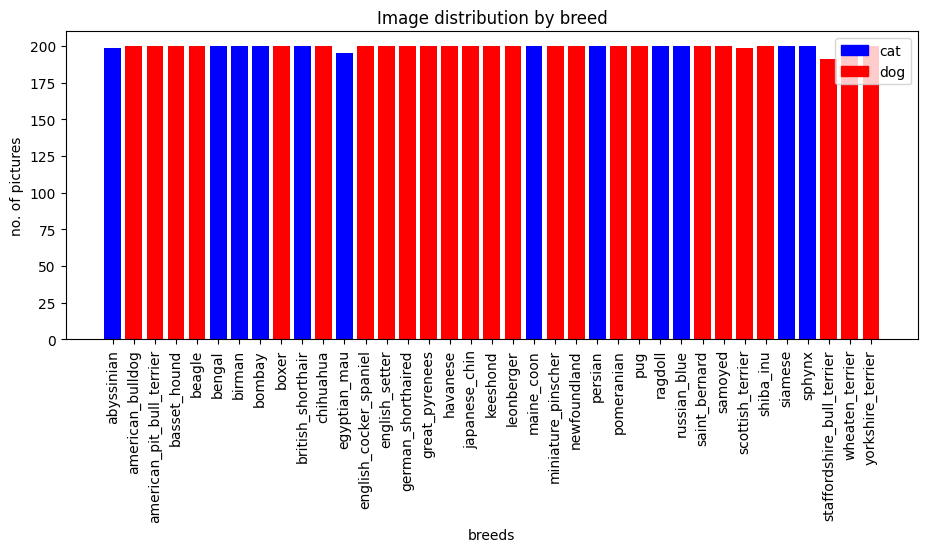

There are 2394 images of cats, and 4990 of dogs!


In [4]:
# Open and read the 'list.txt' file which contains metadata about images
# Information is extracted into 2 dictionaries: info_by_id and info_by_breed
l = open(ROOT + '/annotations/annotations/list.txt', 'r')
# Define lambda functions to extract breed from the image filename and species
get_breed = lambda pic : pic.rsplit('_',1)[0].lower()
get_species = lambda num : 'cat' if num==1 else 'dog'

# Initialize dictionaries to store information by ID and by breed
info_by_id = {}
info_by_breed = {}

# Process each line in the list.txt, skipping comments
for line in l:
  if line[0] == '#':
    continue
  line = line.strip().split(' ')
  species = get_species(int(line[2]))
  id = int(line[1])
  breed_id = int(line[3])
  name = get_breed(line[0]).lower()
  # Populate the dictionaries with data if the breed is not already in the dictionary
  if name not in info_by_breed:
    info_by_breed[name] = {'breed' : name, 'species' : species, 'global_id': id, 'breedid':breed_id, 'count':0}
    info_by_id[id] = info_by_breed[name]

# Increment the count of images for each breed based on the image files processed
for p in [get_breed(n) for n in all_imgs]:
  info_by_breed[p]['count']+=1

# Prepare data for plotting a bar chart of image distribution by breed
ids = list(info_by_id.keys())
counts = [info_by_id[id]['count'] for id in ids]
x_labels = [info_by_id[i]['breed'] for i in ids]
colours = [ 'blue' if info_by_id[id]['species']=='cat' else 'red' for id in ids]

# Create legend
colours_leg = {'cat': 'blue', 'dog':'red'}
labels = list(colours_leg.keys())
handles = [plt.Rectangle((0,0),1,1, color=colours_leg[label]) for label in colours_leg]

# Plotting the chart
fig, ax = plt.subplots( figsize= (11,4))
ax.bar(ids, counts, color=colours)
ax.set_xticks(ids)
ax.set_xticklabels(x_labels, rotation='vertical')
plt.legend(handles, labels)
plt.xlabel('breeds')
plt.ylabel('no. of pictures')
plt.title('Image distribution by breed')
plt.show()

no_cats = sum([ info_by_id[id]['count'] for id in ids if info_by_id[id]['species'] == 'cat' ])
no_dogs = sum([ info_by_id[id]['count'] for id in ids if info_by_id[id]['species'] == 'dog' ])
print('There are ' + str(no_cats) + ' images of cats, and ' + str(no_dogs) + ' of dogs!')

Functions to process images and labels for training and saves it to pickle file

In [6]:
# Set the pixel size of the images to be resized to
IMG_SIZE = 299

def getXy(rem_background=False, imgs=None):
  # Lambda function to get the global ID of a breed based on the image file name
  get_class_no = lambda name : info_by_breed[get_breed(name)]  ['global_id']
  
  training_data = []
  
  for img in all_imgs:
    path = os.path.join(IMGS_PATH, img)
  
    # Load the image in RGB format (OpenCV defaults to BGR)
    img_array = cv2.imread(path)[...,::-1] 
  
    # Optional removal of background
    if rem_background:
      trimap_filename = img.rsplit('.', 1)[0] + '.png'
      if trimap_filename in all_trimaps:
        tri_array = cv2.imread(os.path.join(TRIMAP_PATH, trimap_filename))
        # Set background pixels (where trimap==2) to 0, and foreground to 1
        tri_array[tri_array==2] = 0
        tri_array[tri_array>0] = 1       
        # Remove the background by multiplying the image by the trimap
        img_array = np.multiply(tri_array, img_array)

    # Resize the image to the specified IMG_SIZE
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  
    # Retrieve the ID for the current image
    class_no = get_class_no(img)
  
    if imgs is not None and class_no not in imgs:
      imgs[class_no] = path

    # Append the processed image and its class number to the training data
    training_data.append([img_array, class_no])
    
  # Randomly shuffle the training data to ensure the model trains on a diverse set
  random.shuffle(training_data)
  
  # Separate the images and labels from the training data
  training = list(zip(*training_data))
  X = training[0]
  y = training[1]
  
  # Convert the list of images to a numpy array and reshape for use
  X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  return X, y

# Define a function to save data objects to a file using pickle
def save(obj, fic_name, open_type='wb'):
  pickle_out = open(fic_name, open_type)
  pickle.dump(obj, pickle_out)
  pickle_out.close()

# Dictionary to potentially map class IDs to image paths
imgs = {}

# Execute the function to get the processed images and labels, and save them
X, y = getXy(imgs=imgs, rem_background=False)
save(X, 'X.pickle')
save(y, 'y.pickle')

# Print the shape of the X array to verify its dimensions
print(X.shape)

(7384, 299, 299, 3)


## Part 2: Training

Load in data and split it into training and testing sets.

In [7]:
# Loading files
# To test with other files (for example, with the background removed) this file names should be changed to the appropriate ones and everything works fine
X = pickle.load(open("X.pickle","rb"))
X = np.array(X)

y = pickle.load(open("y.pickle","rb"))
y = np.array(y)

# Split data into training and testing data
# This split is stratified, which means that the ratios between the numbers of images in each class will be kept equal in the testing set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Function to create a TensorFlow model based on InceptionV3 architecture. It includes options for dropout rate, learning rate, and whether to use data augmentation. The model uses frozen weights from InceptionV3 trained on ImageNet for feature extraction, followed by custom layers for further learning specific to the dataset in question.

In [11]:
def getModel(dropout=.25, learning_rate=0.001, augmentation=False):
    # Load the InceptionV3 model pre-trained on ImageNet, excluding the top layer, set for feature extraction
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    # Freeze the base_model layers to prevent them from being trained
    base_model.trainable = False

    # Define the input tensor with the expected shape of images
    inputs = tf.keras.Input(shape=(299, 299, 3))
    
    # Conditional to apply data augmentation techniques if augmentation is set to True
    if augmentation:
        x = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),  # randomly flips images horizontally
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),  # randomly rotates images up to 20% of 360 degrees
        ])(inputs)
    else:
        x = inputs  # use the original input if no augmentation is applied

    # Pre-process the inputs using InceptionV3's preprocessing function
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    # Pass the processed inputs through the base model
    x = base_model(x, training=False)
    # Apply global average pooling to reduce dimensionality
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Dense layer for learning features with 256 units and ReLU activation
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    # Apply dropout to prevent overfitting, rate controlled by the dropout parameter
    x = tf.keras.layers.Dropout(dropout)(x)
    # Apply batch normalization for stable and efficient training
    x = tf.keras.layers.BatchNormalization()(x)
    # Final output layer with softmax activation to output probabilities for 37 classes
    outputs = tf.keras.layers.Dense(37, activation='softmax')(x)
    # Create the model with specified inputs and outputs
    model = tf.keras.Model(inputs, outputs)
    # Print model summary to understand its architecture
    model.summary()
    # Compile the model with categorical crossentropy loss, Adam optimizer, and tracking accuracy
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    return model

This function converts the class labels, which are presumably categorical integers, into a one-hot encoded format. One-hot encoding is necessary when modeling categorical outcomes where each class is represented as a binary vector. This is standard practice when preparing data for classification tasks in neural networks.


In [12]:
# Function to encode y to arrays of 0's and 1's so it checks out with the model we have
onehot_encoder = OneHotEncoder(sparse=False)
def onehotencode_func(y):
  integer_encoded = y.reshape(len(y), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  return onehot_encoded

Define hyperparameters and train the model

In [13]:
# Defining values that will be experimented with
l_r = 0.001
d_r = 0.25

# Load the model with specific hyperparameters
model = getModel(learning_rate=l_r, dropout=d_r)

# Train the model
history = model.fit(x_train, onehotencode_func(y_train), batch_size=32, epochs=5, validation_split=0.2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

c:\Users\alexl\anaconda3\envs\ai4robotics\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
130/130 [==============================] - 199s 1s/step - loss: 0.6510 - accuracy: 0.8280 - val_loss: 0.3803 - val_accuracy: 0.9023
Epoch 2/5
130/130 [==============================] - 202s 2s/step - loss: 0.2551 - accuracy: 0.9243 - val_loss: 0.3111 - val_accuracy: 0.8985
Epoch 3/5
130/130 [==============================] - 202s 2s/step - loss: 0.1917 - accuracy: 0.9470 - val_loss: 0.3095 - val_accuracy: 0.9023
Epoch 4/5
130/130 [==============================] - 201s 2s/step - loss: 0.1401 - accuracy: 0.9579 - val_loss: 0.3003 - val_accuracy: 0.9062
Epoch 5/5
130/130 [==============================] - 214s 2s/step - loss: 0.1162 - accuracy: 0.9707 - val_loss: 0.3017 - val_accuracy: 0.9081


After training, plot the accuracy and loss for both training and validation tests to visually assess how well the model is learning and generalising.

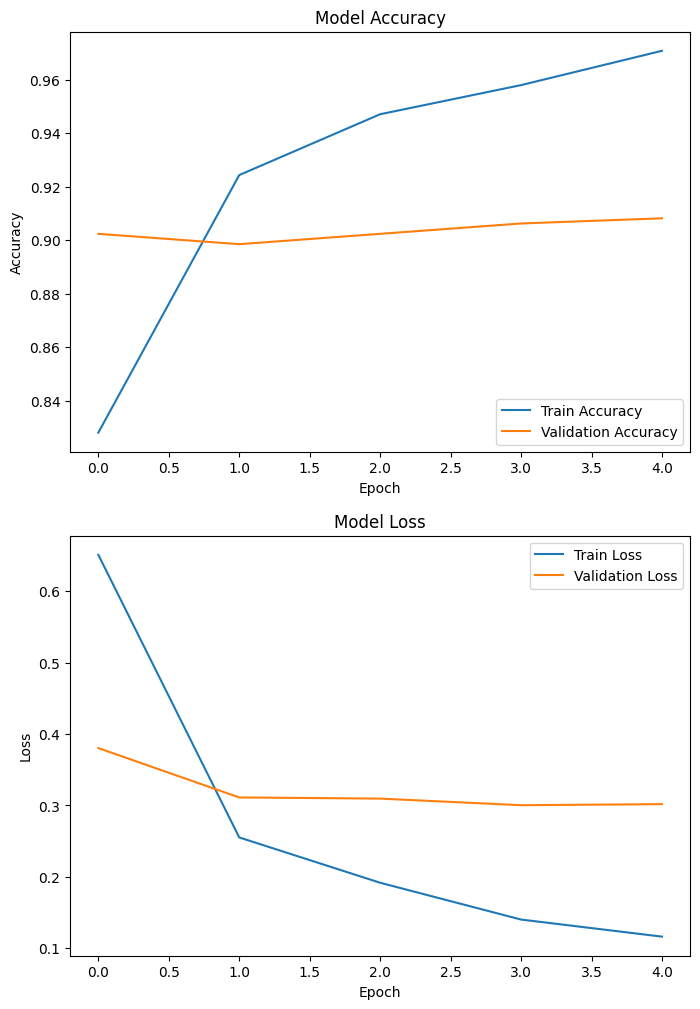

In [14]:
# Plotting training & validation accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

plt.show()

 Now we evaluate the model on the test set.

In [16]:
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred2 = [np.argmax(i)+1 for i in y_pred]

70/70 [==============================] - 80s 1s/step


Following the model evaluation, a confusion matrix is plotted to visualize the model’s performance across different classes. Finally, the classification report provides detailed metrics to help understand the model’s strengths and weaknesses in classifying each breed.

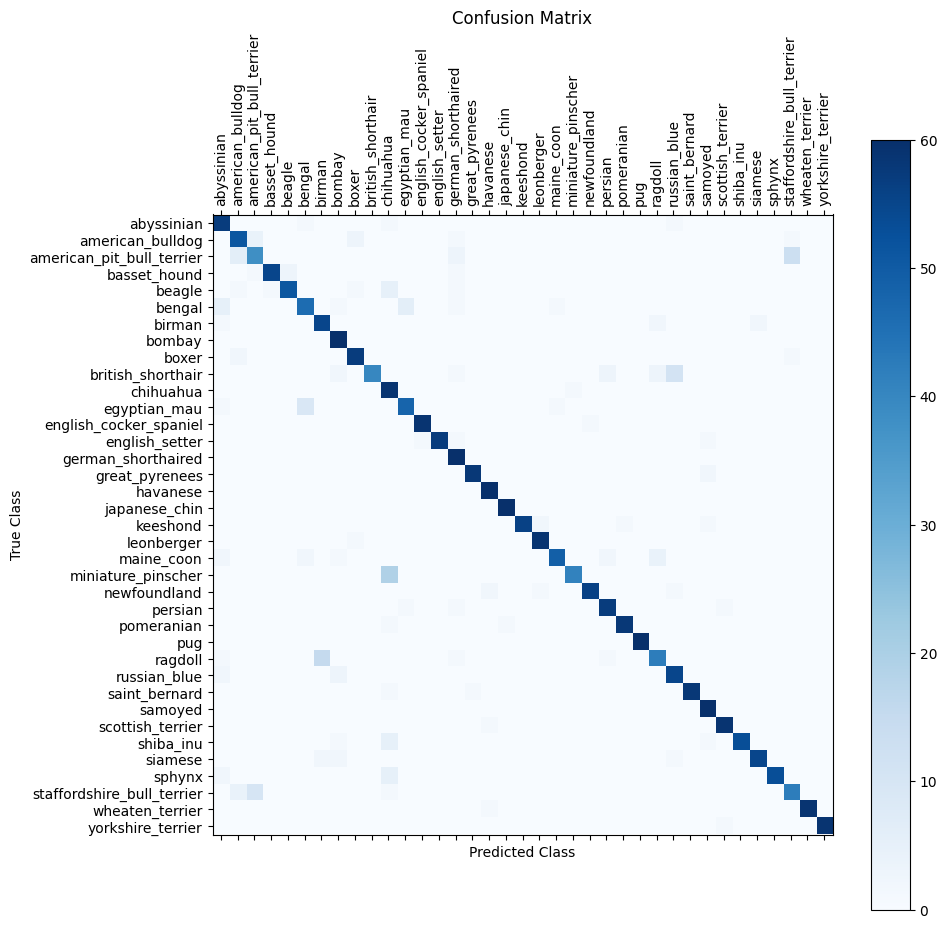

                            precision    recall  f1-score   support

                abyssinian       0.80      0.95      0.87        60
          american_bulldog       0.80      0.85      0.82        60
 american_pit_bull_terrier       0.72      0.63      0.67        60
              basset_hound       0.98      0.92      0.95        60
                    beagle       0.94      0.85      0.89        60
                    bengal       0.79      0.77      0.78        60
                    birman       0.76      0.92      0.83        60
                    bombay       0.86      1.00      0.92        60
                     boxer       0.92      0.95      0.93        60
         british_shorthair       1.00      0.67      0.80        60
                 chihuahua       0.61      0.98      0.75        60
              egyptian_mau       0.87      0.81      0.84        59
    english_cocker_spaniel       0.98      0.98      0.98        60
            english_setter       1.00      0.95

In [17]:
# Create and display the confusion matrix
labels = ['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
cm = metrics.confusion_matrix(y_test, y_pred2, labels=np.arange(1, 38))  # Assuming class labels start from 1 to 37

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
plt.show()

# Print the classification report
print(metrics.classification_report(y_test, y_pred2, target_names=labels))